In [59]:
using Plots
using LinearAlgebra
using LaTeXStrings
include("/home/javier/Desktop/alpcah/alpcah.jl")
include("/home/javier/Desktop/alpcah/helperFunctions.jl");

In [2]:
trials = 10;
D = 100;
d = 10;
v = [0.25, 100];
N = [10, 490];
U = generateSubspace(D, d; seed=0)
Y = generateData(U, v, N; coordinateWindow=33, seed=1);
varianceVector = vcat(v[1]*ones(N[1]), v[2]*ones(N[2]));
YL = []
for i = 1:trials
    Y0 = generateData(U, v, N; coordinateWindow=33, seed=i+1)
    push!(YL,Y0)
end

## Quick Test

In [3]:
U_PCA = PCA(Y, d)
error_pca = affinityError(U,U_PCA)

0.3497479854113086

In [4]:
U_WPCA = weightedPCA(Y,varianceVector,d);
error_wpca = affinityError(U, U_WPCA)

0.1970668377505719

In [5]:
U_HEPPCAT = heppcatWrapper(Y, d)
error_heppcat = affinityError(U,U_HEPPCAT)

0.24697642842822234

In [6]:
U_ALPCAH,_,_ = ALPCAH(Y, d; methodType=:ALPCAH_ALTMIN, alpcahIter= 1000, apgdIter= 5, λr=1.0, μ=0.01, ρ=1.0)
error_alpcah = affinityError(U,U_ALPCAH)

0.24812962289278903

In [7]:
U_ALPCAH,_,_ = ALPCAH(Y, d; methodType=:ALPCAH_APGD, alpcahIter= 1000, apgdIter= 1, λr=1000, μ=0.01, ρ=1.0)
error_alpcah = affinityError(U,U_ALPCAH)

0.213693259875071

In [8]:
U_ALPCAH,_,_ = ALPCAH(Y, d; methodType=:ALPCAH_ADMM, alpcahIter= 1000, apgdIter= 5, λr=10, μ=0.1, ρ=1.0)
error_alpcah = affinityError(U,U_ALPCAH)

0.20767668098195818

## Trials

In [60]:
wpca_list = []; heppcat_list = []; pca_list = []; alpcah_admm_list = []; alpcah_apgd_list = []; alpcah_altmin_list = [];
λr = vcat(0.0:5:100.0); λr[1] = 0.1;
for i=1:trials
    println(i)
    flush(stdout)
    # PCA
    U_PCA = PCA(YL[i], d)
    errorPCA = affinityError(U, U_PCA)
    push!(pca_list, errorPCA)
    # Weighted PCA [known variance]
    U_WPCA = weightedPCA(YL[i], varianceVector, d) 
    errorWPCA = affinityError(U, U_WPCA)
    push!(wpca_list, errorWPCA)
    # HePPCAT [unknown variance]
    U_HEPPCAT = heppcatWrapper(YL[i], d)
    errorHEPPCAT = affinityError(U, U_HEPPCAT)
    push!(heppcat_list,errorHEPPCAT)
    # HePPCAT [unknown variance - ALTMIN]
    U_ALPCAH,_,_ = ALPCAH(YL[i], d; methodType=:ALPCAH_ALTMIN, alpcahIter= 1000, apgdIter= 1, μ=0.1, ρ=1.0)
    errorALPCAH = affinityError(U, U_ALPCAH)
    push!(alpcah_altmin_list, errorALPCAH)
    # ALPCAH [unknown variance - ADMM]
    errorALPCAH = zeros(size(λr))
    Threads.@threads for j=1:length(λr)
        U_ALPCAH,_,_ = ALPCAH(YL[i], d; methodType=:ALPCAH_ADMM, alpcahIter= 1000, apgdIter= 1, λr=λr[j], μ=0.01, ρ=1.01) 
        errorALPCAH[j] = affinityError(U, U_ALPCAH)
    end
    push!(alpcah_admm_list, errorALPCAH)
    # ALPCAH [unknown variance - APGD]
    errorALPCAH = zeros(size(λr))
    Threads.@threads for j=1:length(λr)
        U_ALPCAH,_,_ = ALPCAH(YL[i], d; methodType=:ALPCAH_APGD, alpcahIter= 1000, apgdIter= 1, λr=λr[j], μ=0.1, ρ=1.0) 
        errorALPCAH[j] = affinityError(U, U_ALPCAH)
    end
    push!(alpcah_apgd_list, errorALPCAH)
end

1
2
3
4
5
6
7
8
9
10


In [66]:
heppcat_mean = mean(heppcat_list); pca_mean = mean(pca_list); wpca_mean = mean(wpca_list); 
alpcah_admm_mean = mean(alpcah_admm_list); alpcah_apgd_mean = mean(alpcah_apgd_list); alpcah_altmin_mean = mean(alpcah_altmin_list);
colors = theme_palette(:auto).colors

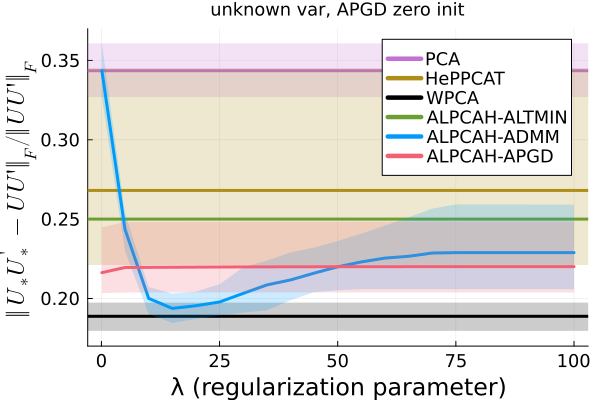

In [72]:
plot(xlabel="λ (regularization parameter)",ylim=(0.17,0.37),ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F", title="unknown var, APGD zero init")
plot!(legend_position=:topright, legendfontpointsize=12,xtickfontsize=12,ytickfontsize=12,guidefontsize=16,titlefontsize=12)
# NO λ METHODS
hline!([pca_mean],ribbon=(pca_mean-minimum(pca_list),maximum(pca_list)-pca_mean),c=colors[4], fillalpha = 0.2,linewidth=3, label="PCA")
hline!([heppcat_mean],ribbon=(heppcat_mean-minimum(heppcat_list),maximum(heppcat_list)-heppcat_mean), c=colors[5], fillalpha = 0.2, linewidth=3, label="HePPCAT")
hline!([wpca_mean],ribbon=(wpca_mean-minimum(wpca_list),maximum(wpca_list)-wpca_mean), c=:black, linewidth=3,fillalpha = 0.2, label="WPCA")
#hline!([alpcah_altmin_mean],ribbon=(alpcah_altmin_mean-minimum(alpcah_altmin_list),maximum(alpcah_altmin_list)-alpcah_altmin_mean), c=colors[end], linewidth=3,fillalpha = 0.2, label="ALPCAH-ALTMIN")
hline!([alpcah_altmin_mean], c=colors[end], linewidth=3,fillalpha = 0.2, label="ALPCAH-ALTMIN")
# ALPCAH-ADMM
maxValue = vec(maximum(reduce(vcat,transpose.(alpcah_admm_list)),dims=1))
minValue = vec(minimum(reduce(vcat,transpose.(alpcah_admm_list)),dims=1))
plot!(λr,alpcah_admm_mean, ribbon=(alpcah_admm_mean .- minValue, maxValue .- alpcah_admm_mean), fillalpha = 0.2, c=colors[1], linewidth=3, label="ALPCAH-ADMM")
# ALPCAH-APGD
maxValue = vec(maximum(reduce(vcat,transpose.(alpcah_apgd_list)),dims=1))
minValue = vec(minimum(reduce(vcat,transpose.(alpcah_apgd_list)),dims=1))
plot!(λr,alpcah_apgd_mean, ribbon=(alpcah_apgd_mean .- minValue, maxValue .- alpcah_apgd_mean), fillalpha = 0.2, c=colors[end-2], linewidth=3, label="ALPCAH-APGD")
#savefig("alpcah_comparisons_zeroinit.pdf")